In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

# Importar todos as bases de dados (banco de dados de 2021 atualizado e 2022 até fevereiro)

df_list = []
data = []
anos_list = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
index_inicial = anos_list[0]
index_contador = 0

for x in range(len(anos_list)):
  concatenate_index = str(anos_list[0] + x)
  globals()['df%s' % concatenate_index] = pd.DataFrame(data)

  csv_string = "/content/drive/My Drive/acidentes/por_ocorrencia/datatran" + str(index_inicial) + ".csv"
  index_inicial = index_inicial + 1
  df_list.append(pd.read_csv(csv_string, sep=";", encoding="latin-1"))
  
for df in df_list:
 locals()["df"+str(anos_list[0] + index_contador)] = df
 locals()["df"+str(anos_list[0] + index_contador)]["data_inversa"] = pd.to_datetime(locals()["df"+str(anos_list[0] + index_contador)]["data_inversa"])
 locals()["df"+str(anos_list[0] + index_contador)] = locals()["df"+str(anos_list[0] + index_contador)].sort_values(by=['data_inversa'])
 index_contador = index_contador + 1

Mounted at /content/drive


In [2]:
quantidade_removida = "Foram removidas "
anos_duplicados = []

for i in range(len(anos_list)):
  tamanho_inicial = len(locals()["df"+str(anos_list[i])].index)
  print("Qtd corrências",str(anos_list[i])+":",tamanho_inicial)

# Remover dados com o ID duplicado (Não faz sentido um banco de dados por ocorrência possuir o mesmo id)
  if locals()["df"+str(anos_list[i])]["id"].duplicated().any():
    locals()["df"+str(anos_list[i])].drop_duplicates(subset=["id"], inplace=True)
    quantidade_removida = quantidade_removida + str(tamanho_inicial-len(locals()["df"+str(anos_list[i])].index)) + " ocorrências em " + str(anos_list[i]) + ", "
  print("Qtd ocorrências ajustada",str(anos_list[i])+":",len(locals()["df"+str(anos_list[i])].index))
  print("Dados duplicados removidos em",str(anos_list[i])+":",tamanho_inicial-len(locals()["df"+str(anos_list[i])].index))

print(quantidade_removida)

Qtd corrências 2007: 127675
Qtd ocorrências ajustada 2007: 127671
Dados duplicados removidos em 2007: 4
Qtd corrências 2008: 141043
Qtd ocorrências ajustada 2008: 141038
Dados duplicados removidos em 2008: 5
Qtd corrências 2009: 158646
Qtd ocorrências ajustada 2009: 158646
Dados duplicados removidos em 2009: 0
Qtd corrências 2010: 183469
Qtd ocorrências ajustada 2010: 183465
Dados duplicados removidos em 2010: 4
Qtd corrências 2011: 192326
Qtd ocorrências ajustada 2011: 192322
Dados duplicados removidos em 2011: 4
Qtd corrências 2012: 184568
Qtd ocorrências ajustada 2012: 184561
Dados duplicados removidos em 2012: 7
Qtd corrências 2013: 186748
Qtd ocorrências ajustada 2013: 186745
Dados duplicados removidos em 2013: 3
Qtd corrências 2014: 169201
Qtd ocorrências ajustada 2014: 169197
Dados duplicados removidos em 2014: 4
Qtd corrências 2015: 122161
Qtd ocorrências ajustada 2015: 122158
Dados duplicados removidos em 2015: 3
Qtd corrências 2016: 96363
Qtd ocorrências ajustada 2016: 96362


In [3]:
# Quantidade de Acidentes por dia a cada Ano (banco de dados de 2021 atualizado e 2022 até fevereiro)

auxilio_exec = anos_list[0] + len(anos_list) - 1          # Necessário para poder executar o código sem que plataforma reclame de variável não criada

for x in range(len(anos_list)):
  concatenate_index = str(anos_list[0] + x)
  globals()['dfAcidentes%s' % concatenate_index] = pd.DataFrame(data)

  locals()["dfAcidentes"+str(anos_list[0] + x)] = locals()["df"+str(anos_list[0] + x)]['data_inversa'].value_counts()
  locals()["dfAcidentes"+str(anos_list[0] + x)] = locals()["dfAcidentes"+str(anos_list[0] + x)].to_frame()
  locals()["dfAcidentes"+str(anos_list[0] + x)] = locals()["dfAcidentes"+str(anos_list[0] + x)].sort_index()
  if anos_list[0] + x >= anos_list[1]:
    locals()["dfAcidentes"+str(anos_list[0] + x)] = locals()["dfAcidentes"+str(anos_list[0] + x)].append(locals()["dfAcidentes"+str(anos_list[0] + x - 1)])
  elif x == len(anos_list):
    locals()["dfAcidentes"+str(anos_list[0] + x)] = locals()["dfAcidentes"+str(anos_list[0] + x)].dropna()

locals()['dfAcidentes%s' % auxilio_exec]        # Em nosso caso específico, essa variável também pode ser escrita como dfAcidentes2022

# Transformar em valores mensais utilizando o somatório
df2022AcidentesM = locals()["dfAcidentes2022"].resample(rule='M').sum()
#df2022AcidentesM = df2022AcidentesM.reset_index(level=0)
df2022AcidentesM = df2022AcidentesM.rename(columns={"index": "Date", "data_inversa": "Acidentes"})
df2022AcidentesM

,Acidentes
2007-01-31,10611
2007-02-28,9624
2007-03-31,9997
2007-04-30,10191
2007-05-31,10489
...,...
2021-10-31,5756
2021-11-30,5084
2021-12-31,5802
2022-01-31,5018


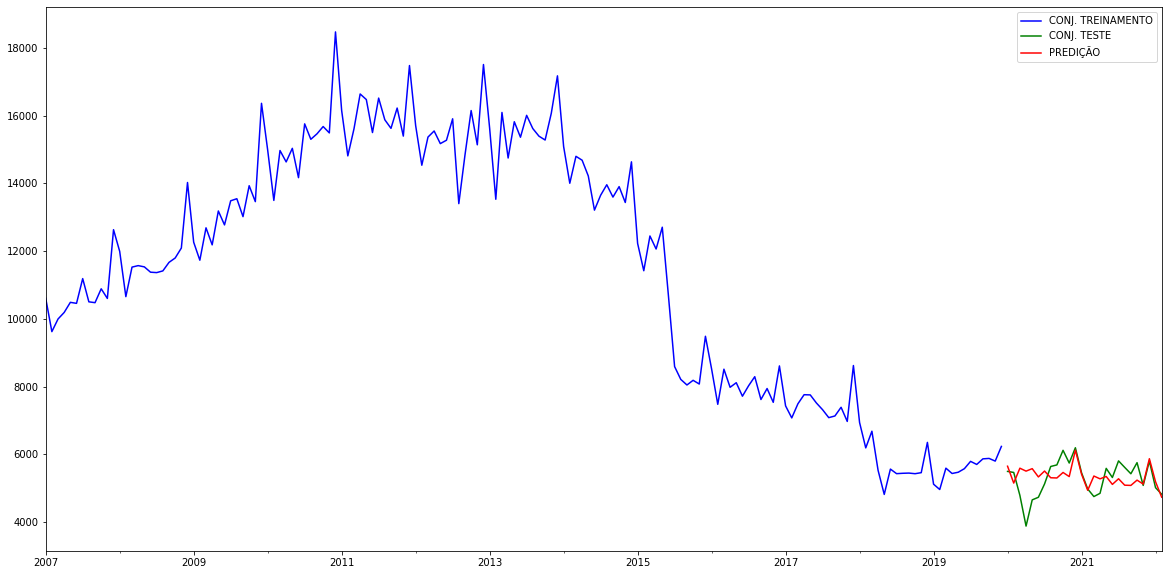

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error

# Treinando o modelo até dezembro de 2019
train_data = df2022AcidentesM.loc[:'2019-12-31']
test_data = df2022AcidentesM.loc['2020-01-01':]

fitted_model = ExponentialSmoothing(train_data["Acidentes"], trend="mul", seasonal="mul", seasonal_periods=12).fit()

test_predictions = fitted_model.forecast(26) # 48 meses


# Visualizar nosso modelo de treino e o de teste
train_data["Acidentes"].plot(legend=True,label="CONJ. TREINAMENTO",figsize=(20,10), color='blue')
test_data["Acidentes"].plot(legend=True,label="CONJ. TESTE", color='green')
test_predictions.plot(legend=True,label="PREDIÇÃO", color='red')

In [16]:
mean_absolute_error(test_data["Acidentes"], test_predictions)

403.04425032316675